#### Practical 42 Processing a seismogram

In this practical we will go through the basic steps of downloading and processing seismograms. 


First import the required libraries. The main one used here is ObsPy, whith is a Python toolkit built specifically for seismological data. See www.obspy.org. 


In [1]:
%matplotlib inline

import sys
print(sys.path)

import obspy  # Python toolkit for common routines in seismology
from obspy.clients.fdsn import Client
from obspy import UTCDateTime # Converts strings of dates
from obspy.taup import TauPyModel # Predicts travel times
import numpy as np # General array seismology routines
import matplotlib.pyplot as plt # Plotting routines
import math

['/Users/sanne/Documents/Teaching/ESB_2023/Practicals/Practical 2', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python38.zip', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/lib-dynload', '', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages', '/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/IPython/extensions', '/Users/sanne/.ipython']


/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### 1. Download data

Firstly we set up a client which connects us to the server of IRIS (Incorporated Research Institutions for Seismology, www.iris.edu). IRIS hosts seismological data collected around the globe, both from permanent and temporary seismic networks, as well as other geophysicsl data. 


In [3]:
client = Client("IRIS") # sets connection to IRIS database

Next, we set the details of the data we want to download. 

In [4]:
# event 1 = "2018-12-20T17:01:55", event 2=  "2019-06-24T02:54"
eventtime= "2018-12-20T17:01:55"
network="BK"
stationname="CMB"

We use the client to obtain location and magnitude information on the event. This gets stored in an ObsPy defined [event class](https://docs.obspy.org/packages/autogen/obspy.core.event.event.Event.html).

1 Event(s) in Catalog:
2018-12-20T17:01:55.150000Z | +55.100, +164.699 | 7.3 mww
depth is 16.56  km


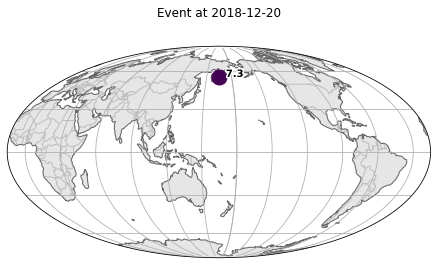

In [11]:
# Obtain event information
event = client.get_events(starttime=UTCDateTime(eventtime)-200, endtime=UTCDateTime(eventtime)+200, minmagnitude=6, catalog="NEIC PDE")
print(event)
print('depth is', event[0].origins[0].depth/1.e3, ' km')
event.plot()
plt.show()

Next we download information for a specific station into a [station inventory object](https://docs.obspy.org/packages/autogen/obspy.core.inventory.station.Station.html).

/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/sanne/opt/anaconda3/envs/instaseis/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_lin

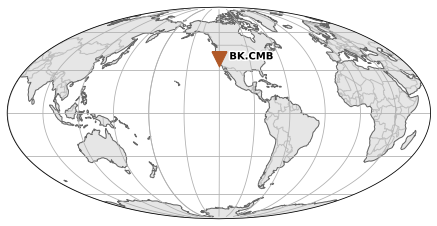

In [10]:
# Note that replacing network and stationname with "*" would provide all stations available at the time of the earthquake
t = event[0].origins[0].time
station = client.get_stations(network=network, station=stationname, channel='BH*', starttime=t-200, endtime=t+200, level='response')
station.plot()
plt.show()

Next we download the actual data into a [Stream format](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html). A Stream is a list of [Traces](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html#obspy.core.trace.Trace), which stores continuous data as well as metadata. 

In [7]:
# We downlaod the first 5000 seconds after the event time
[sbef,saft] = [0,5000]
seis = client.get_waveforms(network,stationname,"*", "BH*", t-sbef, t+saft, attach_response = True)
print(seis)

3 Trace(s) in Stream:
BK.CMB.00.BHE | 2018-12-20T17:01:55.169536Z - 2018-12-20T18:25:15.144536Z | 40.0 Hz, 200000 samples
BK.CMB.00.BHN | 2018-12-20T17:01:55.169536Z - 2018-12-20T18:25:15.144536Z | 40.0 Hz, 200000 samples
BK.CMB.00.BHZ | 2018-12-20T17:01:55.169536Z - 2018-12-20T18:25:15.144536Z | 40.0 Hz, 200000 samples


### 2. Compute geometry

Using the information from the earthquake and station, we can now compute the distance to the station, the azimuth (the angle at the earthquake between North and the direction to the station) and the backazimuth (the angle at the station between North and the direction to the earthquake). 

In [13]:
# Get distance, azimuth and backazimuth from event and station locations
distm, azimuth, back_azimuth =  obspy.geodetics.base.gps2dist_azimuth(event[0].origins[0]['latitude'],
                                                        event[0].origins[0]['longitude'],
                                                          station[0][0].latitude,
                                                          station[0][0].longitude)
# Convert distnace from m to epicentral degrees
distdg = distm/(6371.e3*np.pi/180.)

#print results
print('distance in epicentral degrees = ', np.round(distdg,1))
print('azimuth from event to station = ', np.round(azimuth,1))
print('backazimuth from station to event = ', np.round(back_azimuth,1))

distance in epicentral degrees =  51.6
azimuth from event to station =  76.3
backazimuth from station to event =  315.1


### 3.  Remove instrument response

Seismometers record their response to ground motions. This response is frequency and instrument dependent. Each instrument is calibrated and its response is stored. To use the date we need to 'deconvolve' the behaviour of the instrument from the seismogram. 

We first plot the instrument response. Which is given as a so-called [Bode plot](https://en.wikipedia.org/wiki/Bode_plot), showing the station sensitivity and phase shift as a function of frequency. We are looking at a broadband station, which is designed to be sensitive over a broad range of frequencies. 

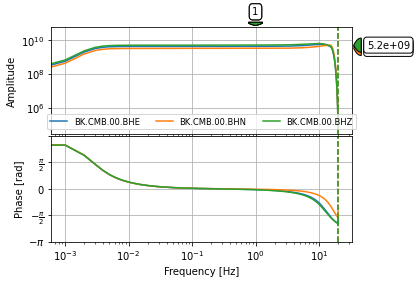

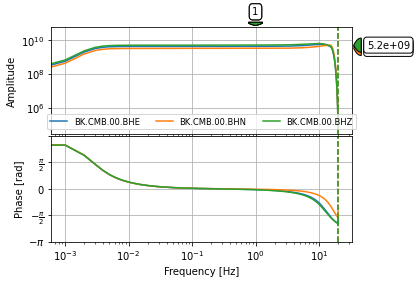

In [13]:
station.plot_response(min_freq=0.001)

The maximum frequency recorded is the Nyquist frequency, defined as 
$$ f_{Nyq}=\frac{1}{2\Delta T}$$
where $\Delta T$ is the sampling interval of the recorded data. 

a. For this station the sampling rate is 20Hz. What is the Nyquist frequency? Does this agree with the Bode plot? 

We won't worry about the technicalities of actually deconvolving the data. Below ObsPy does this for us. Note the change in the amplitudes before and after deconvolution. The y-axis is now in [m/s], instead of the station-specific unit [counts]. 

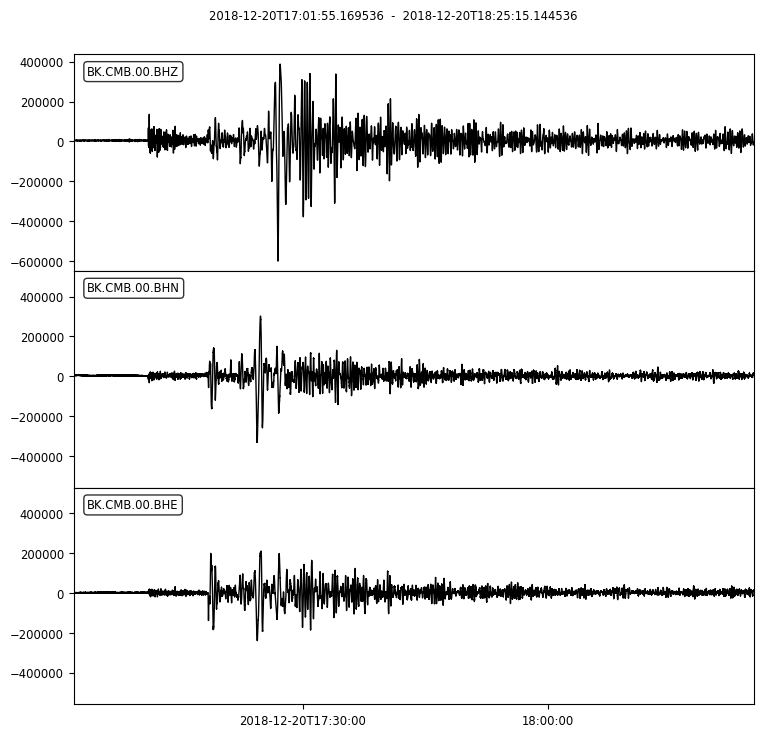

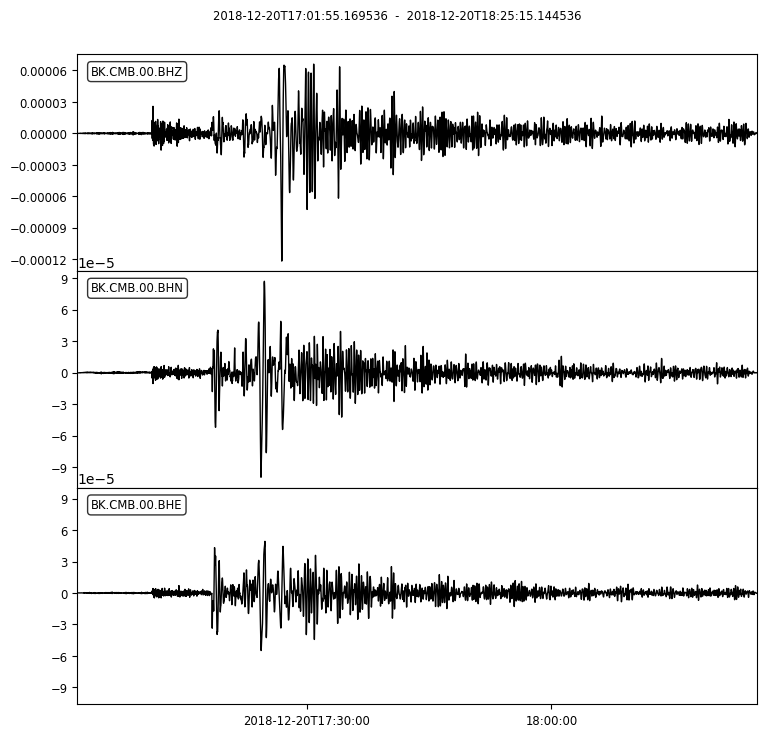

In [14]:
# remove instrument response

pre_filt = [0.001, 0.005, 2, 5]
seis.plot()
seis_resp=seis.copy()
seis_resp.remove_response(output='VEL', pre_filt=pre_filt)
seis_resp.plot()
plt.show()

### 4. Rotate components

<div>
<img src="components.png" width="300"/>
</div>

###### Figure 1 Geometry of North/East and Radial/Transverse components and the definition of the backazimuth

We rotate the horizontal components to the radial and transverse components. The radial component is defined as the direction of propogation for the direct waves, and the transverse component is orthogonal to that. This puts the P and SV energy on the radial and vertical, and the SH energy on the transverse component. 

The rotation is given by a rotation matrix as a function of angle, a, which is 180 degrees from the backazimuth: 

$$ \begin{bmatrix}R\\T\end{bmatrix} =  \begin{bmatrix}cos(a)& sin(a)\\ -sin(a)&cos(a)\end{bmatrix}\begin{bmatrix}N\\E\end{bmatrix} $$

b. Run the rotation below. Identify rough timings of the P and the S arrivals.

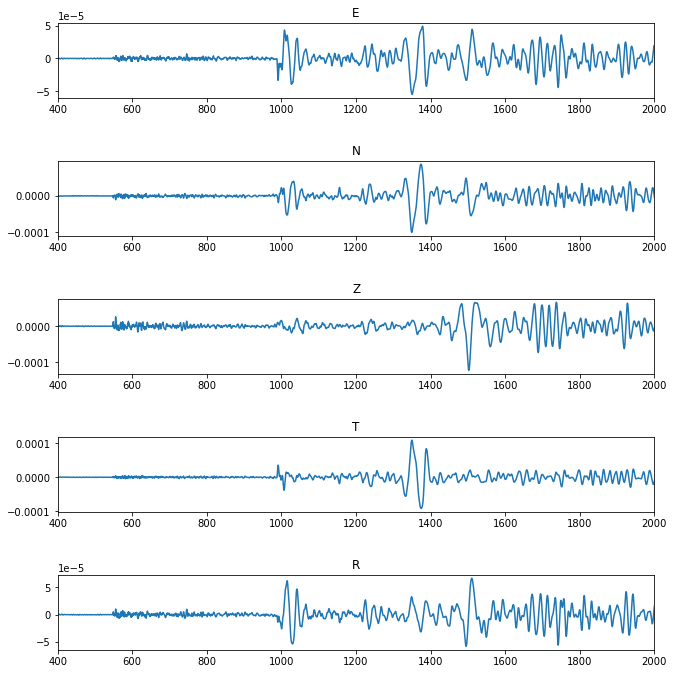

In [20]:

N = seis_resp.select(component='N')[0]
E = seis_resp.select(component='E')[0]


#Rotate components in osbpy
seis_rot=seis_resp.copy()
seis_rot.rotate('NE->RT', back_azimuth=back_azimuth)

xmin=400 #seconds
xmax=2000 #seconds
plt.figure(figsize=(10,10))
plt.subplot(5,1,1)
plt.plot(seis_resp[0].times(), seis_resp[0].data)
plt.title(seis_resp[0].stats['component'])
plt.xlim((xmin,xmax))
plt.subplot(5,1,2)
plt.plot(seis_resp[1].times(), seis_resp[1].data)
plt.title(seis_resp[1].stats['component'])
plt.xlim((xmin,xmax))
plt.subplot(5,1,3)
plt.plot(seis_resp[2].times(), seis_resp[2].data)
plt.title(seis_resp[2].stats['component'])
plt.xlim((xmin,xmax))
plt.subplot(5,1,4)
plt.plot(seis_rot[0].times(), seis_rot[0].data)
plt.title(seis_rot[0].stats['component'])
plt.xlim((xmin,xmax))
plt.subplot(5,1,5)
plt.plot(seis_rot[1].times(), seis_rot[1].data)
plt.title(seis_rot[1].stats['component'])
plt.xlim((xmin,xmax))
plt.tight_layout(pad=3.0)

### 5. Filter data

We can filter the data to emphasize different arrivals. 

c. Try the following filter bands: 

    - 0.001-0.02 Hz
    - 0.02-0.1  Hz
    - 0.125-0.2 Hz
    - 0.5-2. Hz
    
    Which filter bands best emphasizes the P-wave, and S-wave, surface waves? Which filter band is the noisiest? 

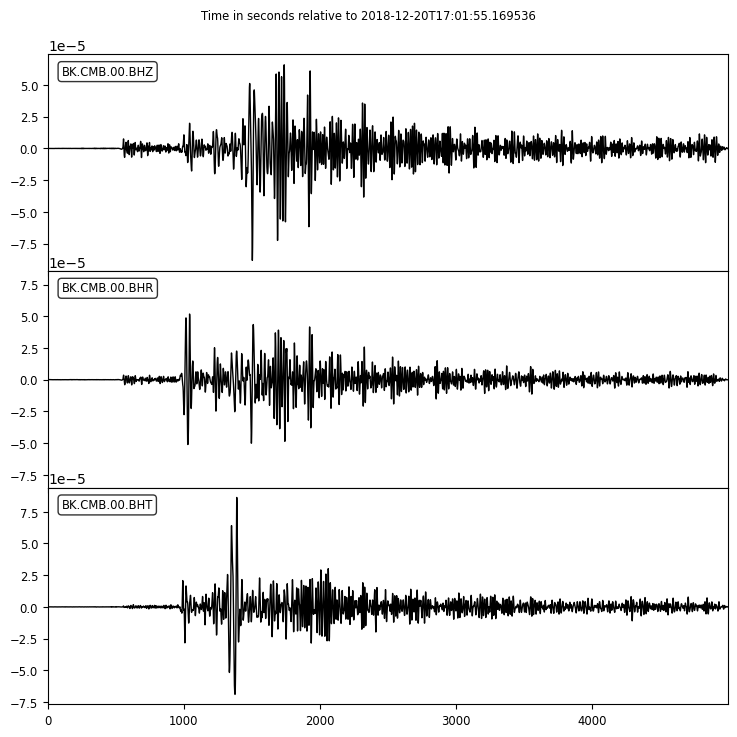

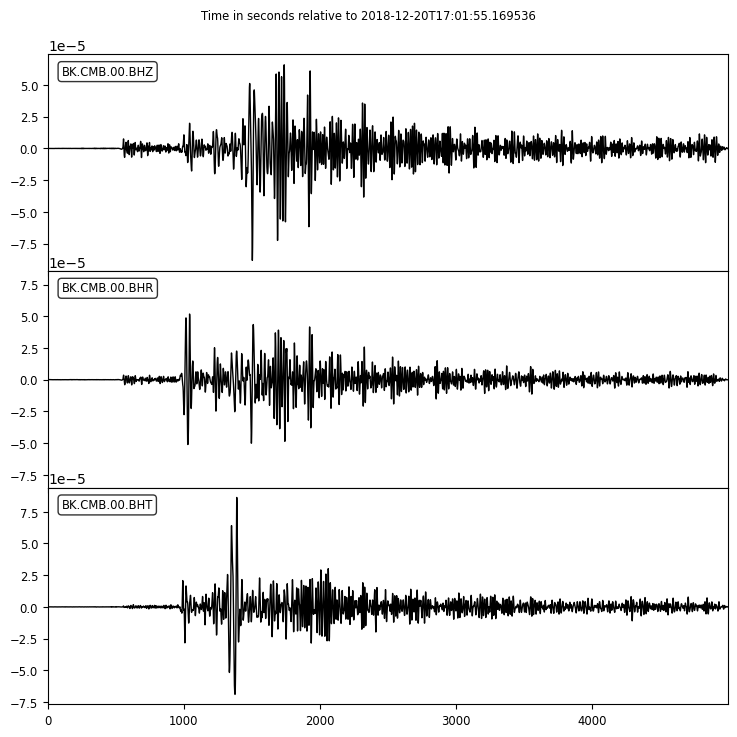

In [16]:

seis_filt =seis_rot.copy()

# set corner frequencies for filter
freqmin=.02
freqmax=.1

seis_filt.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=2, zerophase=True)

seis_filt.plot(type='relative')

### 6.  Identify body waves

In the script below, you can centre the seismogram on a single predicted body wave arrival. 

d. Optimise the filter and the window width to have look at the P and S waves. Which components to they dominantly arrive on and why? 

The ray parameter, $p$, in $[s/rad]$ is given by
$$ p = \frac{r \sin{i}}{v}$$, 
where $r$ is the radius at any point along the ray in $[km/rad]$, $i$ is the incidence angle, and $v$ is the velocity in $[km/s]$. 

e. Use the values given for the ray parameter of the P and S wave and their incidence angles to compute the assumed $V_P$ and $V_S$ at the station. 


P arrives at  545.5 seconds, with a ray parameter of  428.7 s/rad, and an incident angle of  23.0 deg


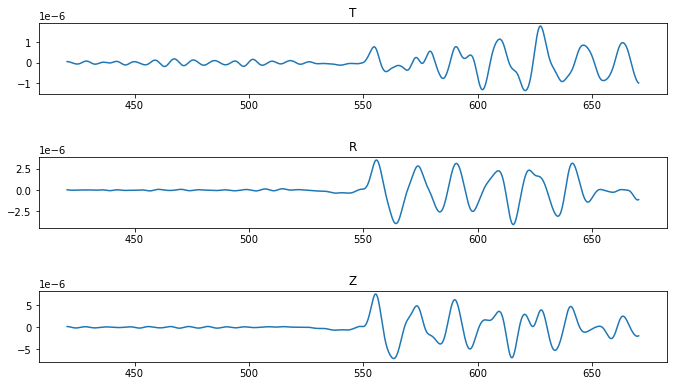

In [17]:
#Identify phase
phase = ['P']
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
arrival = model.get_travel_times(source_depth_in_km=event[0].origins[0]['depth']/1.e3,
                                  distance_in_degree=distdg, phase_list = phase)
print(phase[0], 'arrives at ', np.round(arrival[0].time,1), 'seconds, with a ray parameter of ', np.round(arrival[0].ray_param,1), 's/rad, and an incident angle of ', np.round(arrival[0].incident_angle,1), 'deg')


t_left = 125
t_right = 125

plt.figure(figsize=(10,6))
for i in range(len(seis_filt)):
    plt.subplot(3,1,i+1)
    mask = (seis_filt[i].times()>= arrival[0].time-t_left)& (seis_filt[i].times()<= arrival[0].time+t_right)
    plt.plot(seis_filt[i].times()[mask], seis_filt[i].data[mask])
    plt.title(seis_filt[i].stats['component'])
plt.tight_layout(pad=3.0)

    





### 7. Deep, distant event

Go through the processing for the event at "2019-06-24T02:54". 

f. What is its location, depth, and epicentral distance to the station?

g. Note the value for the backazimuth. Why does rotation barely matter? 

h. Look at filtered full seismograms. Can you identify the surface waves? 

i. Look at the Pdiff and Sdiff waves. On which components can you identify the arrivals. 

j. Use the ray pameter predicted for Pdiff and Sdiff to find the assumed velocity for these waves at the core-mantle boundary. 

k. Look at the SKS and SKKS waves. On which components are these arrivals and why? 
